In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as f
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler as srs
import random
import matplotlib.pyplot as plt
from collections import Counter
import torch.optim as optim

In [3]:
dir = '/Users/endothermiic/Desktop/GitHub/APS360_Project/aps360dataset'
transform = transforms.Compose([transforms.ToTensor(),
         transforms.Resize((224, 224)), # images are either 450 * 600 or 1024 * 1024
                                # all resized to 224 * 224 for ResNet
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# transform input images to match requirements; load all images to all_data
all_data = torchvision.datasets.ImageFolder(dir, transform=transform)

In [4]:
all_data

Dataset ImageFolder
    Number of datapoints: 23344
    Root location: /Users/endothermiic/Desktop/GitHub/APS360_Project/aps360dataset
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [5]:
# use a set, random seed
torch.manual_seed(0)

# find 20% of len(all_data) for 20% test and val sets
test_size = int(len(all_data) * 0.2)

# remaining ~60% is left for training
train_size = int(len(all_data) * 0.6)

extra = len(all_data) - 2 * test_size - train_size

In [6]:
# randomly split the data into training, test and validation sets
train_data, val_data, test_data, extra = torch.utils.data.random_split(all_data,
  [train_size, test_size, test_size, extra])

# use Dataloader to allow for iteration (img, label) over a dataset
# same method used in previous labs
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True)

print("There are {0} images in training, ".format(len(train_loader)))
print("{0} images in validation and ".format(len(val_loader)))
print("{0} images in testing".format(len(test_loader)))

There are 14006 images in training, 
4668 images in validation and 
4668 images in testing


In [7]:
def get_counts(loader):
    # information from dataloader
    labels = [label for img, label in loader.dataset]

    # num / class counted
    counts = dict(Counter(labels))

    return counts

train_counts = get_counts(train_loader)
val_counts = get_counts(val_loader)
test_counts = get_counts(test_loader)

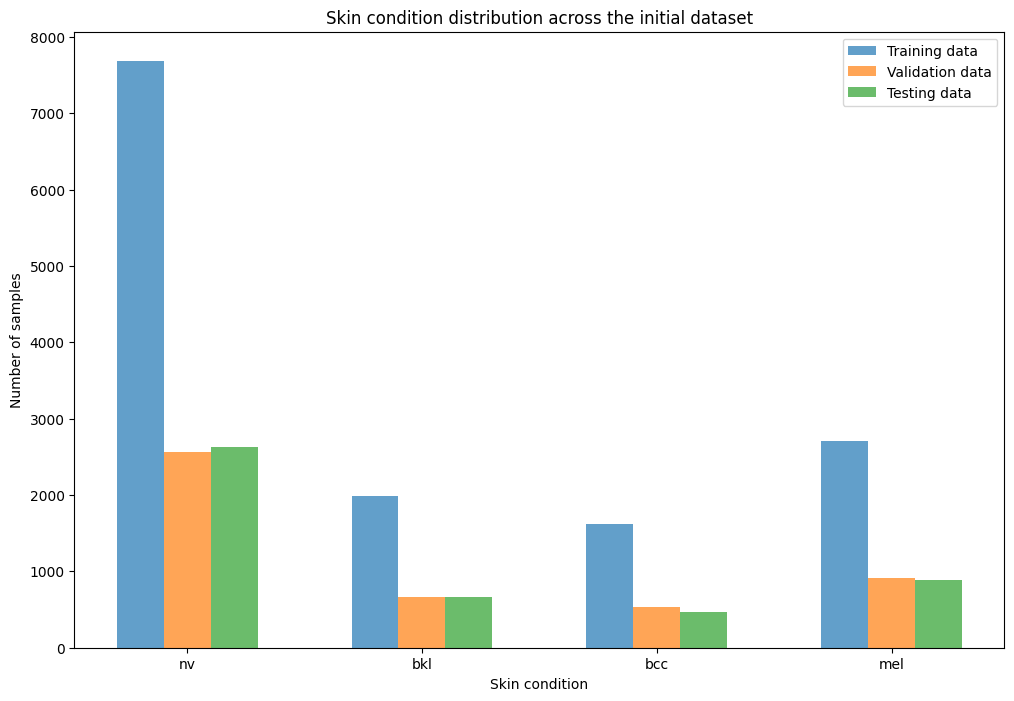

In [8]:
# Pre data augmentation 
labels = ['nv', 'bkl', 'bcc', 'mel']

def plot(train_counts, val_counts, test_counts, title):
    conditions = train_counts.keys()

    train_values = [train_counts.get(c, 0) for c in conditions]
    val_values = [val_counts.get(c, 0) for c in conditions]
    test_values = [test_counts.get(c, 0) for c in conditions]
    
    x = np.arange(len(conditions))
    width = 0.2 
    
    plt.figure(figsize=(12, 8))
    plt.bar(x - width, train_values, width, label='Training data', alpha=0.7)
    plt.bar(x, val_values, width, label='Validation data', alpha=0.7)
    plt.bar(x + width, test_values, width, label='Testing data', alpha=0.7)
    
    plt.xlabel('Skin condition')
    plt.ylabel('Number of samples')
    plt.title(title)
    plt.xticks(x, labels) # can confirm with swapping out conditions here
    plt.legend()
    
    plt.show()


plot(train_counts, val_counts, test_counts, "Skin condition distribution across the initial dataset")


In [9]:
conditions = train_counts.keys()
t_counts = [train_counts.get(c, 0) for c in conditions]
print(f"Training counts: {t_counts}")
v_counts = [val_counts.get(c, 0) for c in conditions]
print(f"Val counts: {v_counts}")
te_counts = [test_counts.get(c, 0) for c in conditions]
print(f"Test counts: {te_counts}")

Training counts: [7682, 1989, 1624, 2711]
Val counts: [2559, 666, 527, 916]
Test counts: [2634, 668, 473, 893]


In [10]:
def augment(data, counts):
    max_count = max(counts)
    augments = [max_count - c for c in counts]

    # transforms for augmentation
    horiz = transforms.RandomHorizontalFlip()
    vert = transforms.RandomVerticalFlip()
    rot = transforms.RandomRotation(90)
    rot_1 = transforms.RandomRotation(270)

    
    augmented_data = []
    all_images = {i: [] for i in range(0, 3)}

    for img, label in data: 
        if label in range(0,3): # minority classes have labels 0, 1, 2
            all_images[label].append((img, label))

    for i in range(0, 3):
        images = all_images[i]
        
        for img, label in images:
            if augments[i + 1] <= 5: # initial class is majority class
                break
            augmented_data.append((horiz(img), label))
            augmented_data.append((vert(img), label))
            augmented_data.append((rot(img), label)) 
            augmented_data.append((rot_1(img), label))
            augments[i + 1] -= 4
            counts[i + 1] += 4
    
    full = data + augmented_data
    return full, counts

In [11]:
aug_test, test_counts = augment(test_data, te_counts)
aug_val, val_counts = augment(val_data, v_counts)
aug_train, train_counts = augment(train_data, t_counts)

In [ ]:
train_loader = torch.utils.data.DataLoader(aug_train, shuffle=True)
val_loader = torch.utils.data.DataLoader(aug_val, shuffle=True)
test_loader = torch.utils.data.DataLoader(aug_test, shuffle=True)

In [12]:
# convert list to dict for visualization
def list_to_dict(counts):
    return {0: counts[1], 1: counts[2], 2: counts[3], 3: counts[0]}

test_dict = list_to_dict(test_counts)
val_dict = list_to_dict(val_counts)
train_dict = list_to_dict(train_counts)

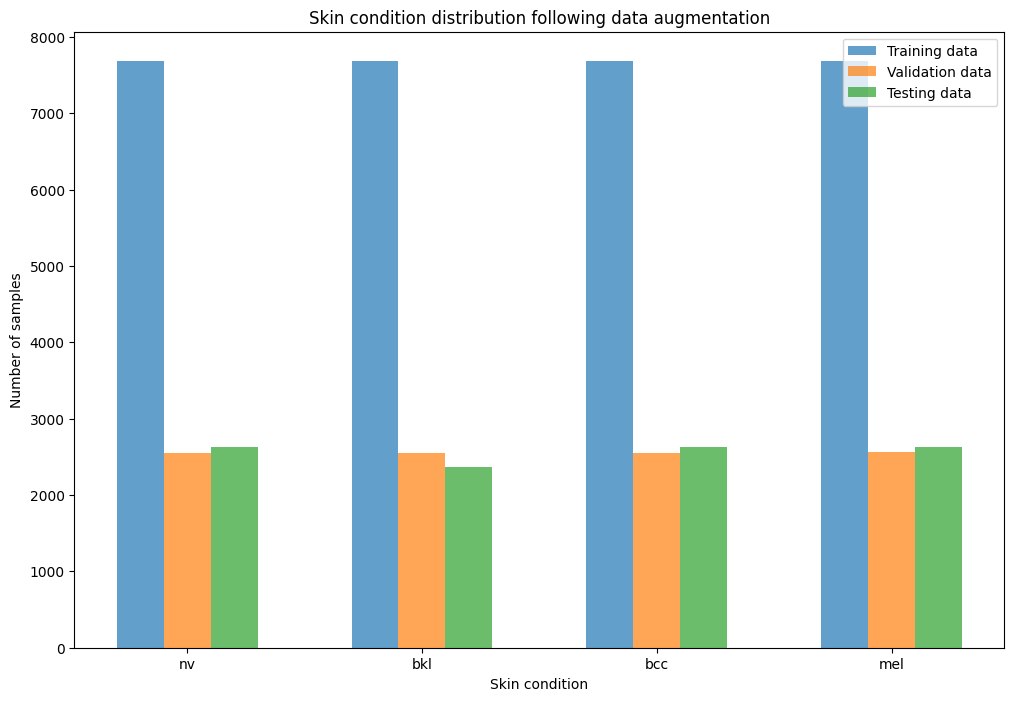

In [14]:
plot(train_dict, val_dict, test_dict, "Skin condition distribution following data augmentation")